# サンプルノートブック
* データのロードから学習・予測、submitファイルの出力までを実行できるサンプルコードです。
* データのパスは実行環境に合わせて設定してください。

In [32]:
#!python3.8 -V

Python 3.8.0


In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import glob

from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# read csv
学習データとテストデータを読み込みます。

In [2]:
# データへのパスは実行環境に合わせて編集してください。
DIR_TRAIN_NORMAL = "data/train/normal/"
DIR_TRAIN_ANOMALY = "data/train/anomaly/"
DIR_TEST = "data/test/"

COL_NAMES = ["ch1","ch2","ch3","ch4","ch5","ch6","ch7"]

In [3]:
data_train_normal = np.empty((0,15000,7))
for f in glob.glob(os.path.join(DIR_TRAIN_NORMAL, "normal_*.csv")):
    data_train_normal = np.concatenate([data_train_normal,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

data_train_anomaly = np.empty((0,15000,7))
for f in glob.glob(os.path.join(DIR_TRAIN_ANOMALY, "anomaly_*.csv")):
    data_train_anomaly = np.concatenate([data_train_anomaly,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

data_test = np.empty((0,15000,7))
for f in glob.glob(os.path.join(DIR_TEST, "data_*.csv")):
    data_test = np.concatenate([data_test,  np.loadtxt(f, delimiter=",").reshape(1,15000,7)], axis=0)

In [4]:
print(data_train_normal.shape)
print(data_train_anomaly.shape)
print(data_test.shape)

(350, 15000, 7)
(90, 15000, 7)
(480, 15000, 7)


# plot
データを可視化してみます。

In [40]:
# X軸（時間軸）の用意
n_samples = data_train_normal.shape[1]
sampling_rate = 50000 #50kHz
x = np.arange(n_samples) / sampling_rate

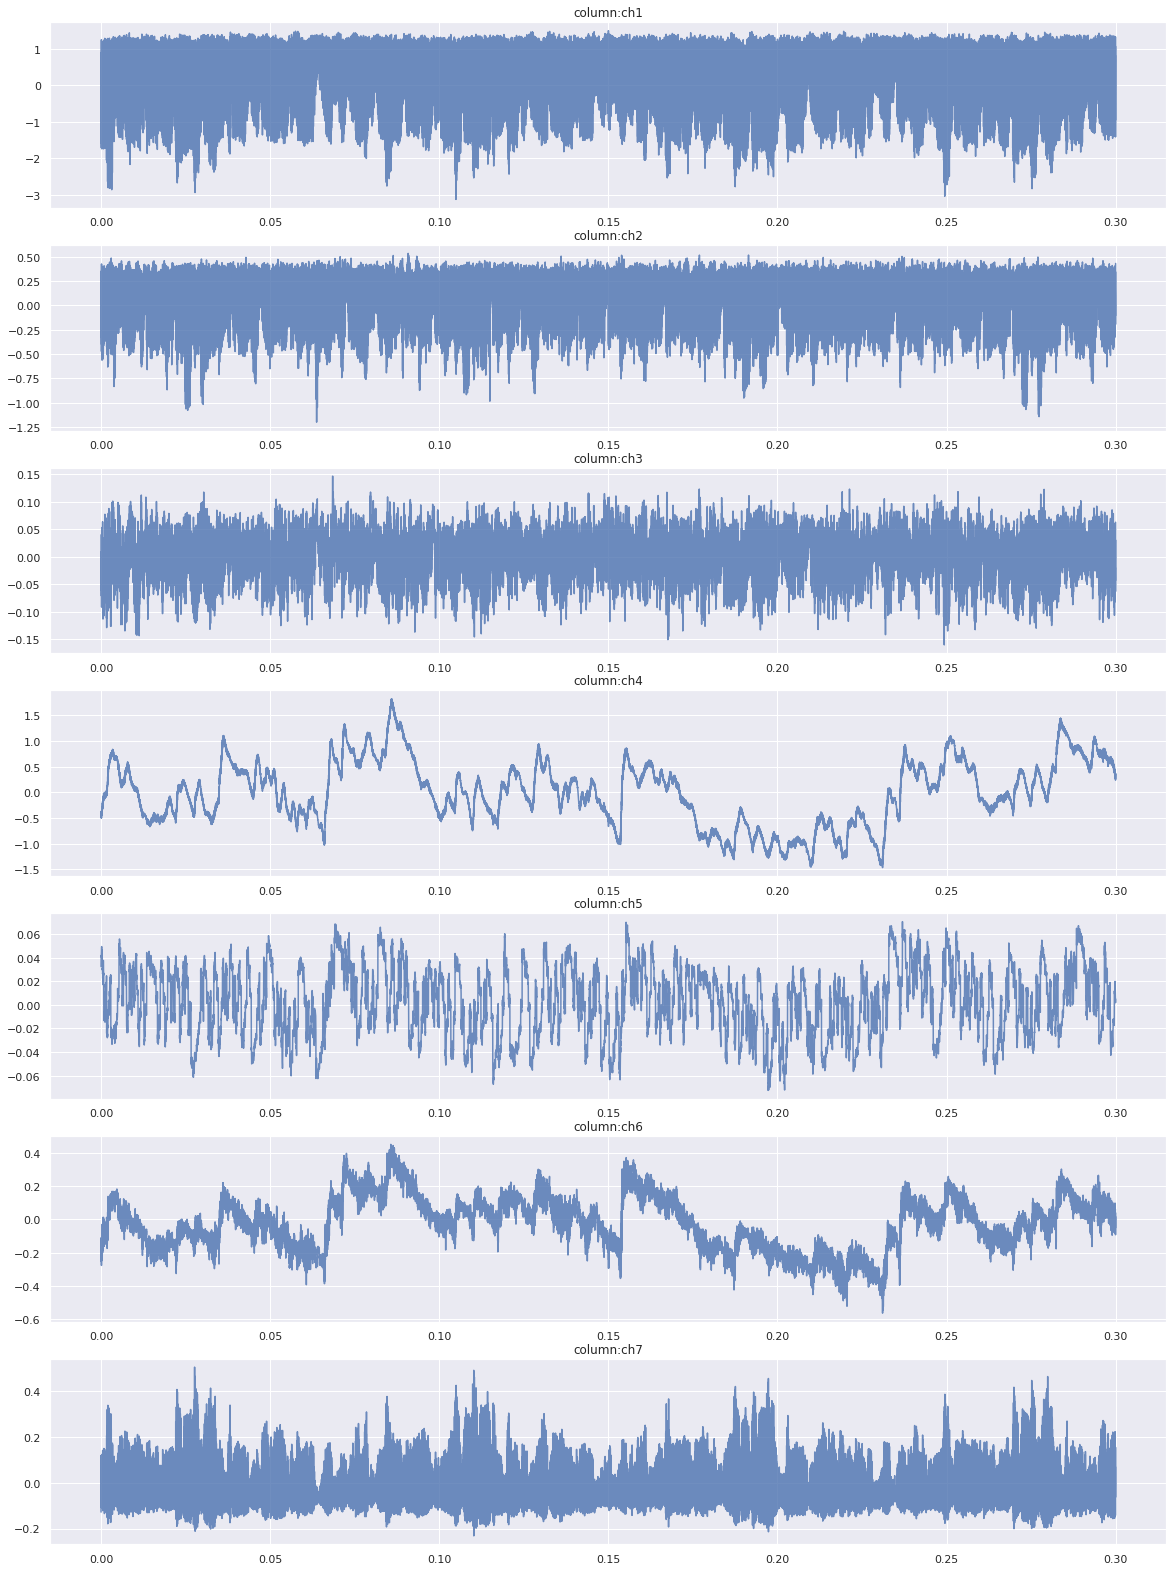

In [42]:
n = 7
f = 0

fix, ax = plt.subplots(n,1, figsize=(20,4*n))

for i in range(n):
    ax[i].plot(x, data_train_normal[f,:,i], alpha=0.8, label="normal")
    ax[i].set_title(f"column:{COL_NAMES[i]}")

# interpolate
データの欠損を補完します。今回は線形補完を実施します。

In [5]:
print(np.sum(np.isnan(data_train_normal)))
# print(np.sum(np.isnan(data_train_normal)))
# print(np.sum(np.isnan(data_train_normal)))

4876


In [6]:
def interpolate(data):
    for i in range(data.shape[0]):
        data[i,:,:] = pd.DataFrame(data[i,:,:]).interpolate(axis=0).values
    return data

data_train_normal = interpolate(data_train_normal)
data_train_anomal = interpolate(data_train_anomaly)
data_test = interpolate(data_test)

In [7]:
print(np.sum(np.isnan(data_train_normal)))

0


# split data
* 学習データをtrainとvalidationにランダムに分割します。
* 正解ラベルを作成します。

In [8]:
# Shuffle train data for validation
## make index list
index_normal = np.arange(0,data_train_normal.shape[0])
index_anomaly = np.arange(0,data_train_anomaly.shape[0])

## shuffle index
np.random.seed(seed=2021)
np.random.shuffle(index_normal)
np.random.shuffle(index_anomaly)

In [9]:
# make train val index
train_size = 0.7
nl = round(len(index_normal)*train_size)
al = round(len(index_anomaly)*train_size)

train_index_normal = index_normal[:nl]
val_index_normal = index_normal[nl:]
train_index_anomaly = index_anomaly[:al]
val_index_anomaly = index_anomaly[al:]

print(len(train_index_normal),len(val_index_normal))
print(len(train_index_anomaly),len(val_index_anomaly))

245 105
63 27


In [10]:
# split X
data_X_train = np.concatenate([data_train_normal[train_index_normal], 
                               data_train_anomaly[train_index_anomaly]], axis=0)
data_X_val = np.concatenate([data_train_normal[val_index_normal], 
                             data_train_anomaly[val_index_anomaly]], axis=0)
data_X_test = data_test
print(f"train:{data_X_train.shape}, val:{data_X_val.shape} test:{data_X_test.shape}")

train:(308, 15000, 7), val:(132, 15000, 7) test:(480, 15000, 7)


In [11]:
# split y
y_train = np.concatenate([[0 for i in range(data_train_normal[train_index_normal].shape[0])], 
                          [1 for i in range(data_train_anomaly[train_index_anomaly].shape[0])]])
y_val = np.concatenate([[0 for i in range(data_train_normal[val_index_normal].shape[0])], 
                        [1 for i in range(data_train_anomaly[val_index_anomaly].shape[0])]])

# train model
* モデルにインプットするデータを標準化します。
* trainデータを使いTimeSeriesForestClassifierモデルを学習します
  * 参考：
  * https://www.sktime.org/en/stable/api_reference/modules/auto_generated/sktime.classification.interval_based.TimeSeriesForestClassifier.html#sktime.classification.interval_based.TimeSeriesForestClassifier
* validationデータで精度を検証します。

In [12]:
scaler = StandardScaler()
sc = scaler.fit(data_X_train.reshape(-1,data_X_train.shape[2]))

data_X_train_norm = sc.transform(data_X_train.reshape(-1,data_X_train.shape[2]))
data_X_train_norm = data_X_train_norm.reshape(data_X_train.shape)

data_X_val_norm = sc.transform(data_X_val.reshape(-1,data_X_val.shape[2]))
data_X_val_norm = data_X_val_norm.reshape(data_X_val.shape)

data_X_test_norm = sc.transform(data_X_test.reshape(-1,data_X_test.shape[2]))
data_X_test_norm = data_X_test_norm.reshape(data_X_test.shape)

In [14]:
# 今回は計算時間短縮のためデータをカット
ts = 5000
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(data_X_train_norm[:,:ts,:], y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify', TimeSeriesForestClassifier(n_estimators=100))])

In [15]:
y_val_pred = clf.predict(data_X_val_norm[:,:ts,:])
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.55      0.41      0.47        27

    accuracy                           0.81       132
   macro avg       0.70      0.66      0.68       132
weighted avg       0.79      0.81      0.80       132



In [16]:
y_val_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

 # predict test
 * テストデータの予測値を算出し、submit用のCSVファイルを出力します。
 

In [17]:
y_test_pred = clf.predict(data_X_test_norm[:,:ts,:])

In [18]:
 y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [19]:
sub = pd.read_csv("sample_submission.csv", header=None)
sub.iloc[:,1] = y_test_pred
sub.to_csv("submission.csv", index=False, header=False)